# GameTheory-13 : Jeux Differentiels et Equilibres de Stackelberg

## Decisions Dynamiques et Leadership Strategique

Ce notebook introduit les **jeux differentiels** (decisions continues dans le temps) et les **equilibres de Stackelberg** (modeles leader-follower).

**Objectifs pedagogiques** :
- Comprendre la difference entre boucle ouverte et boucle fermee
- Maitriser les equilibres de Stackelberg
- Analyser les jeux lineaires-quadratiques (LQ)
- Appliquer a l'economie industrielle (oligopoles dynamiques)

**Prerequis** : Notebooks 1-12, notions de calcul differentiel

**Duree estimee** : 60 minutes

---

## 1. Introduction aux Jeux Dynamiques

### 1.1 Jeux statiques vs dynamiques

| Aspect | Jeux statiques | Jeux dynamiques |
|--------|----------------|------------------|
| **Temps** | Une seule periode | Plusieurs periodes ou continu |
| **Actions** | Simultanees | Sequentielles ou continues |
| **Etat** | Fixe | Evolue selon les actions |
| **Information** | Connue a l'avance | Revelee progressivement |

### 1.2 Types de strategies

- **Boucle ouverte (open-loop)** : le joueur s'engage sur une trajectoire complete $u(t)$ au debut
- **Boucle fermee (closed-loop/feedback)** : le joueur ajuste sa strategie $u(x(t), t)$ selon l'etat courant

### 1.3 Historique

Les jeux differentiels ont ete formalises par **Rufus Isaacs** (1965) dans le contexte de problemes de poursuite-evasion militaires.

In [1]:
# Installation des dependances
import subprocess
import sys

packages = ['numpy', 'scipy', 'matplotlib']
for pkg in packages:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', pkg])

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import minimize, minimize_scalar
from typing import Tuple, Callable, List
from dataclasses import dataclass

print("Imports reussis")

Imports reussis


## 2. Equilibres de Stackelberg

### 2.1 Modele Leader-Follower

Dans un jeu de Stackelberg :
1. Le **leader** choisit son action $x_L$ en premier
2. Le **follower** observe $x_L$ et choisit sa meilleure reponse $x_F(x_L)$
3. Le leader anticipe cette reaction et optimise en consequence

### 2.2 Resolution

**Etape 1** : Trouver la meilleure reponse du follower
$$x_F^*(x_L) = \arg\max_{x_F} \pi_F(x_L, x_F)$$

**Etape 2** : Le leader maximise en substituant
$$x_L^* = \arg\max_{x_L} \pi_L(x_L, x_F^*(x_L))$$

### 2.3 Comparaison avec Cournot

Dans le duopole de Cournot, les firmes choisissent simultanement. Dans Stackelberg, le leader a un **avantage du premier joueur**.

In [2]:
@dataclass
class LinearDemand:
    """Demande lineaire P(Q) = a - bQ."""
    a: float  # Intercept
    b: float  # Pente
    
    def price(self, Q: float) -> float:
        return max(0, self.a - self.b * Q)
    
    def __repr__(self):
        return f"P(Q) = {self.a} - {self.b}Q"


@dataclass
class Firm:
    """Firme avec cout marginal constant."""
    name: str
    marginal_cost: float
    
    def cost(self, q: float) -> float:
        return self.marginal_cost * q
    
    def profit(self, q: float, price: float) -> float:
        return (price - self.marginal_cost) * q


def cournot_equilibrium(demand: LinearDemand, 
                        firm1: Firm, firm2: Firm) -> Tuple[float, float]:
    """
    Calcule l'equilibre de Cournot pour un duopole.
    
    Retourne (q1*, q2*)
    """
    a, b = demand.a, demand.b
    c1, c2 = firm1.marginal_cost, firm2.marginal_cost
    
    # Fonctions de reaction
    # q1 = (a - c1 - b*q2) / (2*b)
    # q2 = (a - c2 - b*q1) / (2*b)
    
    # Resolution du systeme
    q1 = (a - 2*c1 + c2) / (3*b)
    q2 = (a - 2*c2 + c1) / (3*b)
    
    return max(0, q1), max(0, q2)


def stackelberg_equilibrium(demand: LinearDemand,
                            leader: Firm, follower: Firm) -> Tuple[float, float]:
    """
    Calcule l'equilibre de Stackelberg.
    
    Le leader choisit en premier, anticipant la reaction du follower.
    Retourne (q_leader*, q_follower*)
    """
    a, b = demand.a, demand.b
    c_L, c_F = leader.marginal_cost, follower.marginal_cost
    
    # Fonction de reaction du follower
    # q_F(q_L) = (a - c_F - b*q_L) / (2*b)
    
    # Le leader maximise pi_L(q_L, q_F(q_L))
    # pi_L = (a - b*(q_L + q_F) - c_L) * q_L
    # Substitution et derivation -> q_L* = (a - 2*c_L + c_F) / (2*b)
    
    q_L = (a - 2*c_L + c_F) / (2*b)
    q_F = (a - c_F - b*q_L) / (2*b)
    
    return max(0, q_L), max(0, q_F)


# Exemple numerique
demand = LinearDemand(a=100, b=1)
firm_A = Firm("A", marginal_cost=10)
firm_B = Firm("B", marginal_cost=10)

print("Duopole avec demande P(Q) = 100 - Q, couts marginaux c = 10")
print("="*60)

# Cournot
q1_c, q2_c = cournot_equilibrium(demand, firm_A, firm_B)
Q_c = q1_c + q2_c
P_c = demand.price(Q_c)
pi1_c = firm_A.profit(q1_c, P_c)
pi2_c = firm_B.profit(q2_c, P_c)

print(f"\nEquilibre de Cournot (simultane):")
print(f"  q_A = {q1_c:.2f}, q_B = {q2_c:.2f}")
print(f"  Q total = {Q_c:.2f}, Prix = {P_c:.2f}")
print(f"  Profits: pi_A = {pi1_c:.2f}, pi_B = {pi2_c:.2f}")

# Stackelberg avec A leader
q_L, q_F = stackelberg_equilibrium(demand, firm_A, firm_B)
Q_s = q_L + q_F
P_s = demand.price(Q_s)
pi_L = firm_A.profit(q_L, P_s)
pi_F = firm_B.profit(q_F, P_s)

print(f"\nEquilibre de Stackelberg (A leader):")
print(f"  q_A (leader) = {q_L:.2f}, q_B (follower) = {q_F:.2f}")
print(f"  Q total = {Q_s:.2f}, Prix = {P_s:.2f}")
print(f"  Profits: pi_A = {pi_L:.2f}, pi_B = {pi_F:.2f}")

print(f"\nAvantage du leader: {pi_L - pi1_c:.2f} (vs Cournot)")
print(f"Desavantage du follower: {pi_F - pi2_c:.2f} (vs Cournot)")

Duopole avec demande P(Q) = 100 - Q, couts marginaux c = 10

Equilibre de Cournot (simultane):
  q_A = 30.00, q_B = 30.00
  Q total = 60.00, Prix = 40.00
  Profits: pi_A = 900.00, pi_B = 900.00

Equilibre de Stackelberg (A leader):
  q_A (leader) = 45.00, q_B (follower) = 22.50
  Q total = 67.50, Prix = 32.50
  Profits: pi_A = 1012.50, pi_B = 506.25

Avantage du leader: 112.50 (vs Cournot)
Desavantage du follower: -393.75 (vs Cournot)


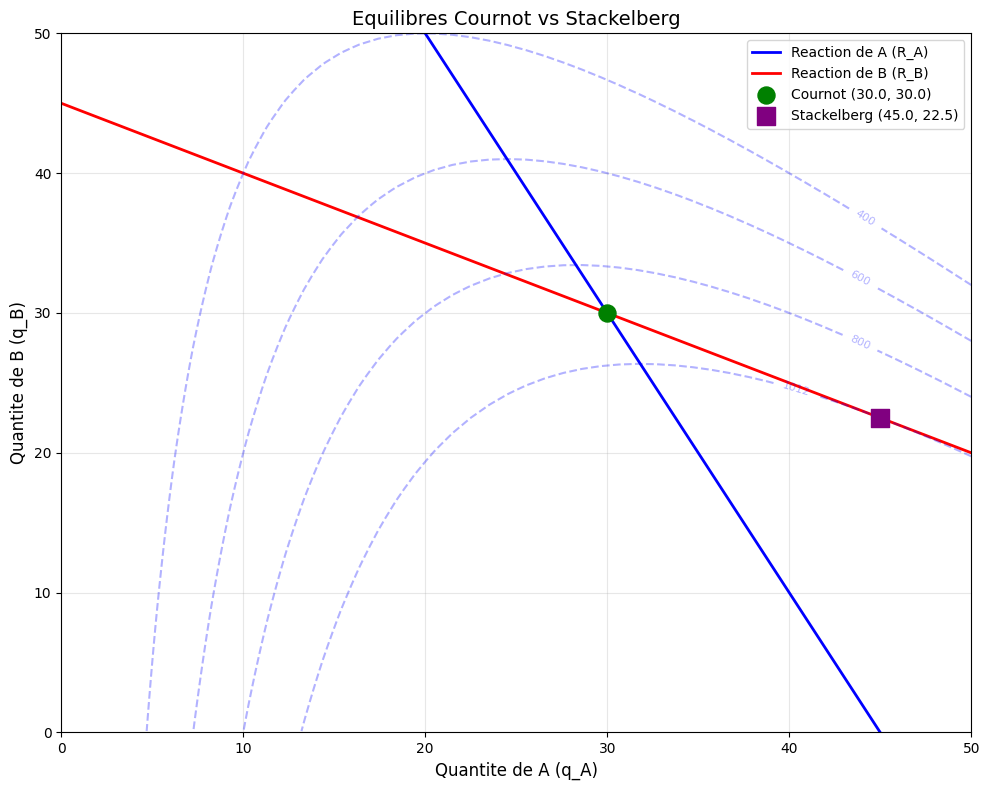

Figure sauvegardee: stackelberg_vs_cournot.png


In [3]:
# Visualisation : fonctions de reaction et equilibres
fig, ax = plt.subplots(figsize=(10, 8))

q_range = np.linspace(0, 50, 100)

# Fonction de reaction de A : q_A = (a - c_A - b*q_B) / (2*b)
def reaction_A(q_B):
    return max(0, (demand.a - firm_A.marginal_cost - demand.b * q_B) / (2 * demand.b))

def reaction_B(q_A):
    return max(0, (demand.a - firm_B.marginal_cost - demand.b * q_A) / (2 * demand.b))

# Tracer les fonctions de reaction
q_A_values = [reaction_A(q_B) for q_B in q_range]
q_B_values = [reaction_B(q_A) for q_A in q_range]

ax.plot(q_A_values, q_range, 'b-', linewidth=2, label="Reaction de A (R_A)")
ax.plot(q_range, q_B_values, 'r-', linewidth=2, label="Reaction de B (R_B)")

# Equilibre de Cournot
ax.scatter([q1_c], [q2_c], s=150, c='green', marker='o', zorder=5,
           label=f"Cournot ({q1_c:.1f}, {q2_c:.1f})")

# Equilibre de Stackelberg
ax.scatter([q_L], [q_F], s=150, c='purple', marker='s', zorder=5,
           label=f"Stackelberg ({q_L:.1f}, {q_F:.1f})")

# Isoprofits du leader (approximation)
q_A_grid = np.linspace(0.1, 50, 50)
q_B_grid = np.linspace(0.1, 50, 50)
Q_A, Q_B = np.meshgrid(q_A_grid, q_B_grid)
Profit_A = (demand.a - demand.b * (Q_A + Q_B) - firm_A.marginal_cost) * Q_A

# Contours d'isoprofit
contours = ax.contour(Q_A, Q_B, Profit_A, levels=[400, 600, 800, pi_L], 
                      colors='blue', alpha=0.3, linestyles='dashed')
ax.clabel(contours, inline=True, fontsize=8, fmt='%.0f')

ax.set_xlabel("Quantite de A (q_A)", fontsize=12)
ax.set_ylabel("Quantite de B (q_B)", fontsize=12)
ax.set_title("Equilibres Cournot vs Stackelberg", fontsize=14)
ax.set_xlim(0, 50)
ax.set_ylim(0, 50)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('stackelberg_vs_cournot.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure sauvegardee: stackelberg_vs_cournot.png")

## 3. Jeux Differentiels : Formalisation

### 3.1 Structure d'un jeu differentiel

Un jeu differentiel a $n$ joueurs est defini par :

- **Dynamique d'etat** : $\dot{x}(t) = f(x(t), u_1(t), ..., u_n(t), t)$
- **Condition initiale** : $x(0) = x_0$
- **Objectifs** : $J_i = \int_0^T g_i(x(t), u_1(t), ..., u_n(t), t) dt + \phi_i(x(T))$

### 3.2 Equilibre de Nash en boucle ouverte

Chaque joueur s'engage sur une trajectoire $u_i^*(t)$ pour $t \in [0, T]$ au debut du jeu.

**Condition d'equilibre** : Pour tout $i$, $u_i^*$ maximise $J_i$ etant donne $u_{-i}^*$.

### 3.3 Equilibre en boucle fermee (feedback)

Les joueurs utilisent des strategies de feedback $u_i(x(t), t)$.

**Avantage** : Robuste aux perturbations et deviations.

In [4]:
class DifferentialGame:
    """
    Classe de base pour les jeux differentiels a 2 joueurs.
    """
    
    def __init__(self, T: float, dt: float = 0.01):
        """
        T: horizon de temps
        dt: pas de discretisation
        """
        self.T = T
        self.dt = dt
        self.times = np.arange(0, T + dt, dt)
    
    def dynamics(self, x: float, u1: float, u2: float, t: float) -> float:
        """Dynamique dx/dt = f(x, u1, u2, t)."""
        raise NotImplementedError
    
    def running_cost_1(self, x: float, u1: float, u2: float, t: float) -> float:
        """Cout instantane pour joueur 1."""
        raise NotImplementedError
    
    def running_cost_2(self, x: float, u1: float, u2: float, t: float) -> float:
        """Cout instantane pour joueur 2."""
        raise NotImplementedError
    
    def terminal_cost_1(self, x_T: float) -> float:
        """Cout terminal pour joueur 1."""
        return 0
    
    def terminal_cost_2(self, x_T: float) -> float:
        """Cout terminal pour joueur 2."""
        return 0
    
    def simulate(self, x0: float, 
                 strategy1: Callable, strategy2: Callable,
                 feedback: bool = False) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        Simule le jeu.
        
        Si feedback=True, strategies sont u(x, t).
        Si feedback=False, strategies sont u(t).
        
        Retourne (times, x_trajectory, u1_trajectory, u2_trajectory)
        """
        n_steps = len(self.times)
        x = np.zeros(n_steps)
        u1 = np.zeros(n_steps)
        u2 = np.zeros(n_steps)
        
        x[0] = x0
        
        for i, t in enumerate(self.times[:-1]):
            if feedback:
                u1[i] = strategy1(x[i], t)
                u2[i] = strategy2(x[i], t)
            else:
                u1[i] = strategy1(t)
                u2[i] = strategy2(t)
            
            # Integration Euler
            dx = self.dynamics(x[i], u1[i], u2[i], t)
            x[i+1] = x[i] + dx * self.dt
        
        # Derniere action
        t = self.times[-1]
        if feedback:
            u1[-1] = strategy1(x[-1], t)
            u2[-1] = strategy2(x[-1], t)
        else:
            u1[-1] = strategy1(t)
            u2[-1] = strategy2(t)
        
        return self.times, x, u1, u2
    
    def compute_costs(self, x: np.ndarray, u1: np.ndarray, 
                      u2: np.ndarray) -> Tuple[float, float]:
        """Calcule les couts totaux des deux joueurs."""
        J1 = 0.0
        J2 = 0.0
        
        for i, t in enumerate(self.times[:-1]):
            J1 += self.running_cost_1(x[i], u1[i], u2[i], t) * self.dt
            J2 += self.running_cost_2(x[i], u1[i], u2[i], t) * self.dt
        
        J1 += self.terminal_cost_1(x[-1])
        J2 += self.terminal_cost_2(x[-1])
        
        return J1, J2


print("Classe DifferentialGame definie")

Classe DifferentialGame definie


## 4. Jeux Lineaires-Quadratiques (LQ)

Les jeux LQ ont une structure speciale qui permet des solutions analytiques.

### 4.1 Structure

- **Dynamique lineaire** : $\dot{x} = Ax + B_1 u_1 + B_2 u_2$
- **Couts quadratiques** : $J_i = \int_0^T (x^T Q_i x + u_i^T R_i u_i) dt$

### 4.2 Solution en boucle ouverte

Les conditions necessaires (Pontryagin) donnent un systeme d'equations differentielles couplees.

### 4.3 Solution en boucle fermee

La strategie optimale est lineaire : $u_i^*(x, t) = -K_i(t) x$

Les matrices $K_i(t)$ satisfont des equations de Riccati couplees.

In [5]:
class LQDifferentialGame(DifferentialGame):
    """
    Jeu differentiel lineaire-quadratique a somme non nulle.
    
    Dynamique: dx/dt = a*x + b1*u1 + b2*u2
    Cout i: Ji = integral(qi*x^2 + ri*ui^2) dt + si*x(T)^2
    """
    
    def __init__(self, T: float, 
                 a: float, b1: float, b2: float,
                 q1: float, r1: float, s1: float,
                 q2: float, r2: float, s2: float,
                 dt: float = 0.01):
        super().__init__(T, dt)
        self.a = a
        self.b1, self.b2 = b1, b2
        self.q1, self.r1, self.s1 = q1, r1, s1
        self.q2, self.r2, self.s2 = q2, r2, s2
    
    def dynamics(self, x: float, u1: float, u2: float, t: float) -> float:
        return self.a * x + self.b1 * u1 + self.b2 * u2
    
    def running_cost_1(self, x: float, u1: float, u2: float, t: float) -> float:
        return self.q1 * x**2 + self.r1 * u1**2
    
    def running_cost_2(self, x: float, u1: float, u2: float, t: float) -> float:
        return self.q2 * x**2 + self.r2 * u2**2
    
    def terminal_cost_1(self, x_T: float) -> float:
        return self.s1 * x_T**2
    
    def terminal_cost_2(self, x_T: float) -> float:
        return self.s2 * x_T**2
    
    def solve_feedback_nash(self) -> Tuple[np.ndarray, np.ndarray]:
        """
        Resout l'equilibre de Nash en boucle fermee.
        
        Retourne les gains K1(t) et K2(t) tels que ui = -Ki*x.
        
        Resolution via equations de Riccati couplees (backward).
        """
        n = len(self.times)
        P1 = np.zeros(n)  # Solution Riccati joueur 1
        P2 = np.zeros(n)  # Solution Riccati joueur 2
        K1 = np.zeros(n)  # Gain feedback joueur 1
        K2 = np.zeros(n)  # Gain feedback joueur 2
        
        # Conditions terminales
        P1[-1] = self.s1
        P2[-1] = self.s2
        
        # Integration backward
        for i in range(n-2, -1, -1):
            # Gains optimaux (derivee de Ji par rapport a ui = 0)
            K1[i+1] = self.b1 * P1[i+1] / self.r1
            K2[i+1] = self.b2 * P2[i+1] / self.r2
            
            # Dynamique effective avec feedback de l'adversaire
            A_cl = self.a - self.b1 * K1[i+1] - self.b2 * K2[i+1]
            
            # Equations de Riccati couplees (version simplifiee)
            dP1 = -(2 * A_cl * P1[i+1] + self.q1 - P1[i+1]**2 * self.b1**2 / self.r1)
            dP2 = -(2 * A_cl * P2[i+1] + self.q2 - P2[i+1]**2 * self.b2**2 / self.r2)
            
            P1[i] = P1[i+1] - dP1 * self.dt
            P2[i] = P2[i+1] - dP2 * self.dt
        
        # Calcul des gains finaux
        for i in range(n):
            K1[i] = self.b1 * P1[i] / self.r1
            K2[i] = self.b2 * P2[i] / self.r2
        
        return K1, K2


# Exemple : Course a l'investissement (publicitaire)
print("Jeu LQ : Course a l'investissement publicitaire")
print("="*60)
print("""\nModele:
- x(t) = part de marche relative (firme 1 - firme 2)
- u1, u2 = efforts publicitaires
- Dynamique: dx/dt = -0.1*x + u1 - u2
- Cout: minimiser x^2 + ui^2 (equilibre + cout d'effort)""")

lq_game = LQDifferentialGame(
    T=10.0, dt=0.05,
    a=-0.1,   # Dissipation naturelle de l'avantage
    b1=1.0, b2=-1.0,  # Impact des efforts (oppose)
    q1=1.0, r1=1.0, s1=0.0,  # Joueur 1 veut x=0 (equilibre)
    q2=1.0, r2=1.0, s2=0.0   # Joueur 2 aussi
)

# Resoudre l'equilibre feedback
K1, K2 = lq_game.solve_feedback_nash()

print(f"\nGains feedback initiaux: K1(0) = {K1[0]:.4f}, K2(0) = {K2[0]:.4f}")

Jeu LQ : Course a l'investissement publicitaire

Modele:
- x(t) = part de marche relative (firme 1 - firme 2)
- u1, u2 = efforts publicitaires
- Dynamique: dx/dt = -0.1*x + u1 - u2
- Cout: minimiser x^2 + ui^2 (equilibre + cout d'effort)

Gains feedback initiaux: K1(0) = 0.4277, K2(0) = -0.4277


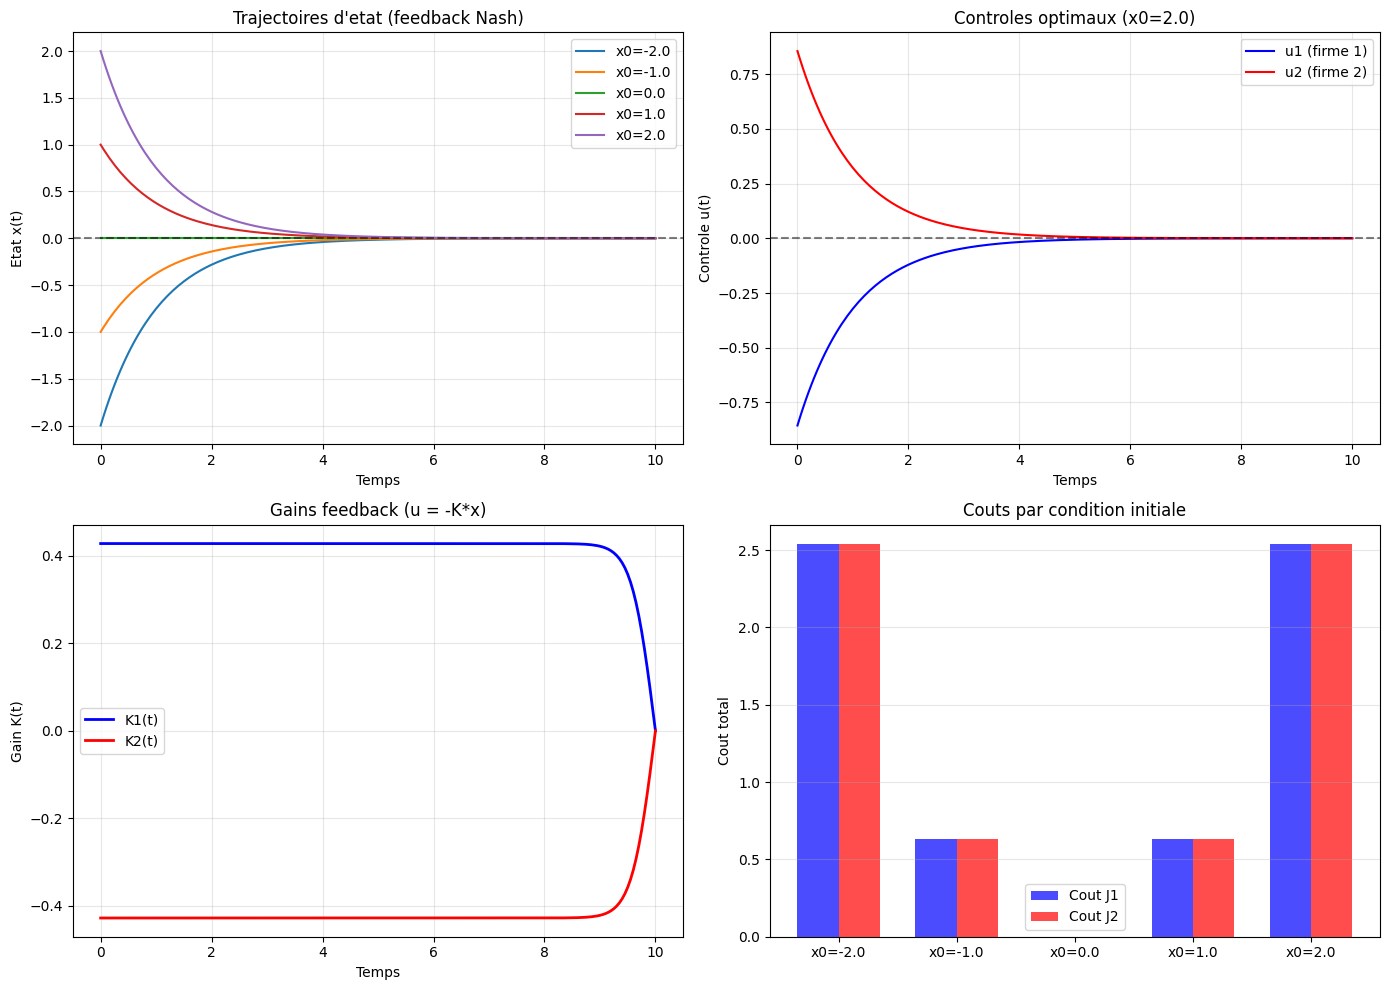

Figure sauvegardee: lq_game_feedback_nash.png


In [6]:
# Simulation avec differentes conditions initiales
x0_values = [-2.0, -1.0, 0.0, 1.0, 2.0]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

all_results = []

for x0 in x0_values:
    # Strategies feedback Nash
    def strategy1_fb(x, t):
        idx = min(int(t / lq_game.dt), len(K1) - 1)
        return -K1[idx] * x
    
    def strategy2_fb(x, t):
        idx = min(int(t / lq_game.dt), len(K2) - 1)
        return -K2[idx] * x
    
    times, x, u1, u2 = lq_game.simulate(x0, strategy1_fb, strategy2_fb, feedback=True)
    J1, J2 = lq_game.compute_costs(x, u1, u2)
    
    all_results.append((x0, times, x, u1, u2, J1, J2))

# Plot trajectoires d'etat
ax1 = axes[0, 0]
for x0, times, x, u1, u2, J1, J2 in all_results:
    ax1.plot(times, x, label=f"x0={x0}")
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax1.set_xlabel('Temps')
ax1.set_ylabel('Etat x(t)')
ax1.set_title('Trajectoires d\'etat (feedback Nash)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot controles
ax2 = axes[0, 1]
for x0, times, x, u1, u2, J1, J2 in all_results:
    if x0 == 2.0:  # Un seul exemple
        ax2.plot(times, u1, 'b-', label='u1 (firme 1)')
        ax2.plot(times, u2, 'r-', label='u2 (firme 2)')
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax2.set_xlabel('Temps')
ax2.set_ylabel('Controle u(t)')
ax2.set_title('Controles optimaux (x0=2.0)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot gains K(t)
ax3 = axes[1, 0]
ax3.plot(lq_game.times, K1, 'b-', linewidth=2, label='K1(t)')
ax3.plot(lq_game.times, K2, 'r-', linewidth=2, label='K2(t)')
ax3.set_xlabel('Temps')
ax3.set_ylabel('Gain K(t)')
ax3.set_title('Gains feedback (u = -K*x)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot couts
ax4 = axes[1, 1]
x0s = [r[0] for r in all_results]
J1s = [r[5] for r in all_results]
J2s = [r[6] for r in all_results]

width = 0.35
x_pos = np.arange(len(x0s))
ax4.bar(x_pos - width/2, J1s, width, label='Cout J1', color='blue', alpha=0.7)
ax4.bar(x_pos + width/2, J2s, width, label='Cout J2', color='red', alpha=0.7)
ax4.set_xticks(x_pos)
ax4.set_xticklabels([f'x0={x0}' for x0 in x0s])
ax4.set_ylabel('Cout total')
ax4.set_title('Couts par condition initiale')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('lq_game_feedback_nash.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure sauvegardee: lq_game_feedback_nash.png")

## 5. Stackelberg Dynamique

### 5.1 Open-Loop Stackelberg

Le leader annonce sa trajectoire complete $u_L(t)$ pour $t \in [0,T]$ au debut. Le follower repond optimalement.

### 5.2 Feedback Stackelberg

Le leader annonce une strategie de feedback $u_L(x,t)$. Le follower observe $u_L$ et l'etat $x(t)$.

**Probleme** : Le leader doit resoudre un probleme de controle optimal ou l'etat inclut les co-etats du follower.

In [7]:
class StackelbergDuopoly:
    """
    Duopole de Stackelberg dynamique.
    
    Etat: x = stock/capacite
    Controles: u_L, u_F = taux de production
    """
    
    def __init__(self, T: float, dt: float,
                 a: float, b: float,  # Demande P = a - b*Q
                 c_L: float, c_F: float,  # Couts marginaux
                 delta: float = 0.1):  # Facteur d'actualisation
        self.T = T
        self.dt = dt
        self.a, self.b = a, b
        self.c_L, self.c_F = c_L, c_F
        self.delta = delta
        self.times = np.arange(0, T + dt, dt)
    
    def follower_reaction(self, q_L: float) -> float:
        """Meilleure reponse statique du follower."""
        q_F = (self.a - self.c_F - self.b * q_L) / (2 * self.b)
        return max(0, q_F)
    
    def leader_profit(self, q_L: float, q_F: float) -> float:
        """Profit du leader."""
        Q = q_L + q_F
        P = max(0, self.a - self.b * Q)
        return (P - self.c_L) * q_L
    
    def follower_profit(self, q_L: float, q_F: float) -> float:
        """Profit du follower."""
        Q = q_L + q_F
        P = max(0, self.a - self.b * Q)
        return (P - self.c_F) * q_F
    
    def solve_static_stackelberg(self) -> Tuple[float, float, float, float]:
        """Resout l'equilibre de Stackelberg statique."""
        # Optimisation du leader anticipant la reaction du follower
        def leader_objective(q_L):
            q_F = self.follower_reaction(q_L)
            return -self.leader_profit(q_L, q_F)  # Negatif car on minimise
        
        result = minimize_scalar(leader_objective, bounds=(0, self.a / self.b), method='bounded')
        q_L_star = result.x
        q_F_star = self.follower_reaction(q_L_star)
        
        pi_L = self.leader_profit(q_L_star, q_F_star)
        pi_F = self.follower_profit(q_L_star, q_F_star)
        
        return q_L_star, q_F_star, pi_L, pi_F
    
    def simulate_dynamic(self, commitment_level: float = 1.0
                        ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Simule le jeu dynamique.
        
        commitment_level: 1.0 = engagement total (Stackelberg)
                         0.0 = pas d'engagement (Nash-Cournot)
        """
        n = len(self.times)
        q_L = np.zeros(n)
        q_F = np.zeros(n)
        profits_L = np.zeros(n)
        profits_F = np.zeros(n)
        
        # Solution Stackelberg statique
        q_L_stack, q_F_stack, _, _ = self.solve_static_stackelberg()
        
        # Solution Cournot
        q_cournot = (self.a - self.c_L) / (3 * self.b)  # Symetrique
        
        for i in range(n):
            # Interpolation entre Cournot et Stackelberg selon commitment
            q_L[i] = commitment_level * q_L_stack + (1 - commitment_level) * q_cournot
            q_F[i] = self.follower_reaction(q_L[i])
            
            profits_L[i] = self.leader_profit(q_L[i], q_F[i])
            profits_F[i] = self.follower_profit(q_L[i], q_F[i])
        
        return q_L, q_F, profits_L, profits_F


# Analyse du niveau d'engagement
print("Stackelberg Dynamique : Impact du niveau d'engagement")
print("="*60)

duopoly = StackelbergDuopoly(T=10, dt=0.1, a=100, b=1, c_L=10, c_F=10)

commitment_levels = [0.0, 0.25, 0.5, 0.75, 1.0]
results = []

for c in commitment_levels:
    q_L, q_F, pi_L, pi_F = duopoly.simulate_dynamic(commitment_level=c)
    results.append((c, q_L.mean(), q_F.mean(), pi_L.mean(), pi_F.mean()))

print(f"\n{'Engagement':<12} {'q_L':<10} {'q_F':<10} {'pi_L':<12} {'pi_F':<12}")
print("-"*56)
for c, q_L, q_F, pi_L, pi_F in results:
    print(f"{c:<12.2f} {q_L:<10.2f} {q_F:<10.2f} {pi_L:<12.2f} {pi_F:<12.2f}")

print("\n0.0 = Cournot (simultane), 1.0 = Stackelberg (sequentiel)")

Stackelberg Dynamique : Impact du niveau d'engagement

Engagement   q_L        q_F        pi_L         pi_F        
--------------------------------------------------------
0.00         30.00      30.00      900.00       900.00      
0.25         33.75      28.12      949.22       791.02      
0.50         37.50      26.25      984.38       689.06      
0.75         41.25      24.38      1005.47      594.14      
1.00         45.00      22.50      1012.50      506.25      

0.0 = Cournot (simultane), 1.0 = Stackelberg (sequentiel)


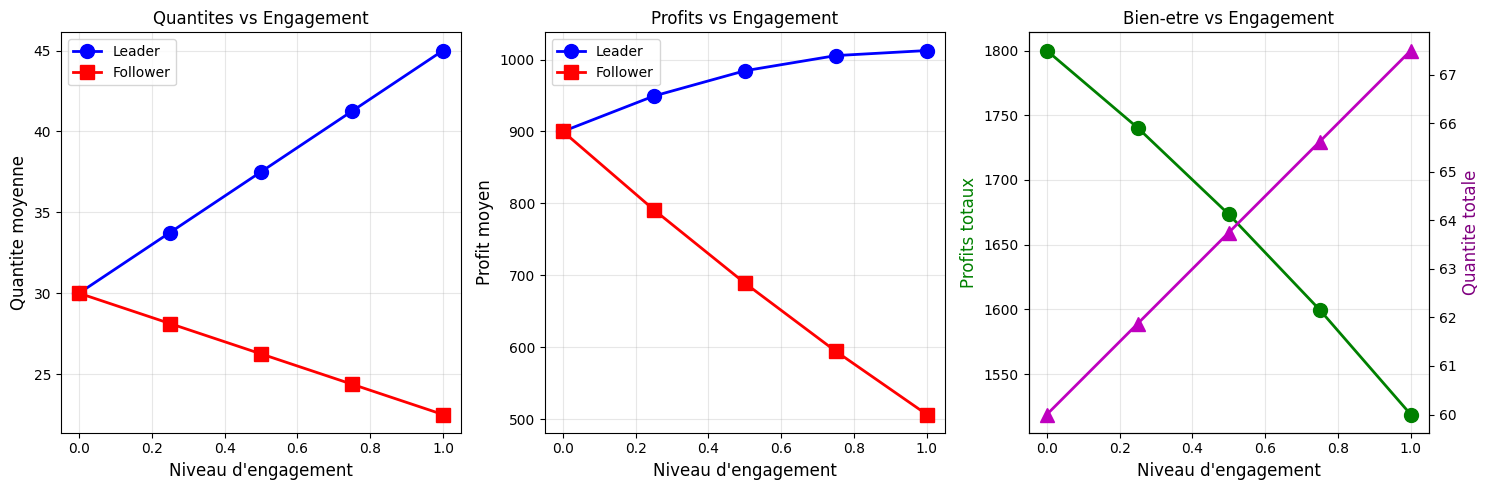


Figure sauvegardee: stackelberg_commitment.png


In [8]:
# Visualisation
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Quantites
ax1 = axes[0]
commitments = [r[0] for r in results]
q_Ls = [r[1] for r in results]
q_Fs = [r[2] for r in results]

ax1.plot(commitments, q_Ls, 'bo-', markersize=10, linewidth=2, label='Leader')
ax1.plot(commitments, q_Fs, 'rs-', markersize=10, linewidth=2, label='Follower')
ax1.set_xlabel('Niveau d\'engagement', fontsize=12)
ax1.set_ylabel('Quantite moyenne', fontsize=12)
ax1.set_title('Quantites vs Engagement')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Profits
ax2 = axes[1]
pi_Ls = [r[3] for r in results]
pi_Fs = [r[4] for r in results]

ax2.plot(commitments, pi_Ls, 'bo-', markersize=10, linewidth=2, label='Leader')
ax2.plot(commitments, pi_Fs, 'rs-', markersize=10, linewidth=2, label='Follower')
ax2.set_xlabel('Niveau d\'engagement', fontsize=12)
ax2.set_ylabel('Profit moyen', fontsize=12)
ax2.set_title('Profits vs Engagement')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Bien-etre total
ax3 = axes[2]
total_profits = [pi_L + pi_F for pi_L, pi_F in zip(pi_Ls, pi_Fs)]
total_quantities = [q_L + q_F for q_L, q_F in zip(q_Ls, q_Fs)]

ax3.plot(commitments, total_profits, 'go-', markersize=10, linewidth=2, label='Profits totaux')
ax3_twin = ax3.twinx()
ax3_twin.plot(commitments, total_quantities, 'm^-', markersize=10, linewidth=2, label='Q total')

ax3.set_xlabel('Niveau d\'engagement', fontsize=12)
ax3.set_ylabel('Profits totaux', color='green', fontsize=12)
ax3_twin.set_ylabel('Quantite totale', color='purple', fontsize=12)
ax3.set_title('Bien-etre vs Engagement')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('stackelberg_commitment.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure sauvegardee: stackelberg_commitment.png")

## 6. Applications Economiques

### 6.1 Competition oligopolistique dynamique

Les modeles de Stackelberg sont utilises pour analyser :
- **Entree sur le marche** : l'incumbent comme leader
- **Capacite de production** : investissements irreversibles
- **Publicite** : campagnes marketing

### 6.2 Regulation

Le regulateur (leader) fixe des regles, les entreprises (followers) s'adaptent.

### 6.3 Commerce international

Pays exportateurs vs importateurs, guerres commerciales.

In [9]:
# Application : Jeu d'entree avec couts fixes
print("Application : Jeu d'entree sur le marche")
print("="*60)

class EntryGame:
    """
    Modele d'entree avec cout fixe et engagement strategique.
    
    Incumbent peut investir en capacite (engagement)
    avant que l'entrant decide d'entrer.
    """
    
    def __init__(self, a: float = 100, b: float = 1,
                 c: float = 10, F: float = 200,
                 k: float = 5):  # Cout par unite de capacite
        self.a, self.b = a, b
        self.c = c  # Cout marginal
        self.F = F  # Cout fixe d'entree
        self.k = k  # Cout de capacite
    
    def incumbent_profit_monopoly(self, K: float) -> float:
        """Profit du monopole avec capacite K."""
        q_monopoly = (self.a - self.c) / (2 * self.b)
        q = min(q_monopoly, K)  # Contraint par la capacite
        P = self.a - self.b * q
        return (P - self.c) * q - self.k * K
    
    def duopoly_equilibrium(self, K: float) -> Tuple[float, float]:
        """Equilibre de Cournot avec incumbent ayant capacite K."""
        # Simplification : incumbent peut produire jusqu'a K
        q_inc = (self.a - 2*self.c + self.c) / (3 * self.b)
        q_ent = (self.a - 2*self.c + self.c) / (3 * self.b)
        
        # Si la capacite est contraignante
        if q_inc > K:
            q_inc = K
            q_ent = (self.a - self.c - self.b * K) / (2 * self.b)
        
        return max(0, q_inc), max(0, q_ent)
    
    def entrant_profit(self, K: float) -> float:
        """Profit de l'entrant si entree."""
        q_inc, q_ent = self.duopoly_equilibrium(K)
        Q = q_inc + q_ent
        P = max(0, self.a - self.b * Q)
        return (P - self.c) * q_ent - self.F
    
    def entry_deterrence_capacity(self) -> float:
        """Capacite minimale pour deterrer l'entree."""
        # Trouver K tel que entrant_profit(K) = 0
        def objective(K):
            return abs(self.entrant_profit(K))
        
        result = minimize_scalar(objective, bounds=(0, 100), method='bounded')
        return result.x
    
    def analyze(self):
        """Analyse complete du jeu."""
        K_deter = self.entry_deterrence_capacity()
        
        # Profits selon les scenarios
        scenarios = {}
        
        # 1. Pas d'engagement, pas d'entree
        K_monopoly = 0
        pi_monopoly = self.incumbent_profit_monopoly(100)  # Capacite illimitee
        scenarios['Monopole sans investissement'] = (0, pi_monopoly, True)
        
        # 2. Entree et duopole
        K_duopoly = 30  # Capacite standard
        q_inc, q_ent = self.duopoly_equilibrium(K_duopoly)
        Q = q_inc + q_ent
        P = self.a - self.b * Q
        pi_duopoly = (P - self.c) * q_inc - self.k * K_duopoly
        scenarios['Duopole'] = (K_duopoly, pi_duopoly, False)
        
        # 3. Deterrence par capacite
        pi_deter = self.incumbent_profit_monopoly(K_deter)
        scenarios['Deterrence par capacite'] = (K_deter, pi_deter, True)
        
        return K_deter, scenarios


entry_game = EntryGame(a=100, b=1, c=10, F=200, k=5)
K_deter, scenarios = entry_game.analyze()

print(f"\nCapacite de deterrence: K* = {K_deter:.2f}")
print(f"Profit entrant si K = K*: {entry_game.entrant_profit(K_deter):.2f}")

print(f"\n{'Scenario':<30} {'Capacite':<12} {'Profit Inc.':<15} {'Monopole?'}")
print("-"*70)
for name, (K, pi, monopole) in scenarios.items():
    print(f"{name:<30} {K:<12.2f} {pi:<15.2f} {monopole}")

Application : Jeu d'entree sur le marche

Capacite de deterrence: K* = 100.00
Profit entrant si K = K*: 700.00

Scenario                       Capacite     Profit Inc.     Monopole?
----------------------------------------------------------------------
Monopole sans investissement   0.00         1525.00         True
Duopole                        30.00        750.00          False
Deterrence par capacite        100.00       1525.00         True


## 7. Exercices

### Exercice 1 : Stackelberg asymetrique

Analysez un duopole de Stackelberg ou le leader et le follower ont des couts marginaux differents ($c_L \neq c_F$).

### Exercice 2 : Jeu LQ a somme nulle

Implementez et resolvez un jeu differentiel a somme nulle (poursuite-evasion).

### Exercice 3 : Commitment value

Calculez la "valeur de l'engagement" : la difference de profit pour le leader entre Stackelberg et Cournot.

### Exercice 4 : Stackelberg a 3 joueurs

Modelisez un jeu avec un leader et deux followers qui reagissent simultanement.

In [10]:
# Espace pour les exercices

# Exercice 3 : Valeur de l'engagement
def commitment_value(demand: LinearDemand, firm_L: Firm, firm_F: Firm) -> float:
    """
    Calcule la valeur de l'engagement = profit_Stackelberg - profit_Cournot
    pour le leader.
    """
    # Cournot
    q1_c, q2_c = cournot_equilibrium(demand, firm_L, firm_F)
    Q_c = q1_c + q2_c
    P_c = demand.price(Q_c)
    pi_cournot = firm_L.profit(q1_c, P_c)
    
    # Stackelberg
    q_L, q_F = stackelberg_equilibrium(demand, firm_L, firm_F)
    Q_s = q_L + q_F
    P_s = demand.price(Q_s)
    pi_stackelberg = firm_L.profit(q_L, P_s)
    
    return pi_stackelberg - pi_cournot

# Test
value = commitment_value(demand, firm_A, firm_B)
print(f"Valeur de l'engagement pour le leader: {value:.2f}")

Valeur de l'engagement pour le leader: 112.50


## 8. Transition vers les jeux cooperatifs

### Du leadership a la cooperation

Dans ce notebook, nous avons vu comment un **leader** peut exploiter son avantage strategique (Stackelberg) en s'engageant avant ses concurrents.

Mais que se passe-t-il si les joueurs decident de **cooperer** plutot que de se faire concurrence ?

### La question de la "valeur" d'une coalition

Dans les jeux cooperatifs (notebook suivant), on s'interesse a :
- **Formation de coalitions** : quels groupes se forment ?
- **Repartition des gains** : comment partager le surplus de la cooperation ?
- **Stabilite** : pourquoi certaines coalitions tiennent et d'autres eclatent ?

### Du Stackelberg a Shapley

| Concept non-cooperatif | Equivalent cooperatif |
|-----------------------|----------------------|
| Avantage du leader | Contribution marginale |
| Equilibre de Nash | Core (stabilite) |
| Best response | Fonction caracteristique |
| Engagement | Formation de coalition |

### Exemple : Course publicitaire → Alliance marketing

Dans le jeu LQ de course publicitaire (section 4), les deux firmes depensent des ressources pour se neutraliser mutuellement.

**Alternative cooperative** : Former une alliance marketing ou les deux firmes coordonnent leurs efforts. La **valeur de Shapley** permet alors de repartir equitablement les gains de cette cooperation.

Cette transition naturelle nous amene au notebook 14 sur les **jeux cooperatifs**.

---

## 9. Resume et Points Cles

### Ce que nous avons appris

1. **Jeux dynamiques** : les decisions se deroulent dans le temps
2. **Boucle ouverte vs fermee** : engagement vs adaptation
3. **Stackelberg** : avantage du premier joueur par engagement
4. **Jeux LQ** : solutions analytiques via equations de Riccati
5. **Applications** : oligopoles, entree, regulation

### Formules cles

| Concept | Formule |
|---------|--------|
| Reaction follower (duopole lineaire) | $q_F(q_L) = \frac{a - c_F - b \cdot q_L}{2b}$ |
| Stackelberg (leader) | $q_L^* = \frac{a - 2c_L + c_F}{2b}$ |
| Feedback LQ | $u^*(x,t) = -K(t) \cdot x$ |
| Valeur engagement | $\Delta \pi = \pi_{Stack} - \pi_{Cournot}$ |

### Comparaison des equilibres

| Aspect | Cournot | Stackelberg |
|--------|---------|-------------|
| Timing | Simultane | Sequentiel |
| Output total | Plus bas | Plus haut |
| Prix | Plus haut | Plus bas |
| Profit leader | Standard | Avantage |
| Bien-etre | Moindre | Meilleur |

---

**Notebook suivant** : [GameTheory-14-CooperativeGames](GameTheory-14-CooperativeGames.ipynb) - Jeux cooperatifs, valeur de Shapley et formation de coalitions